# Map layer preparation

## Setup

In [1]:
from pathlib import Path
from urllib.parse import urlencode

import geopandas as gpd
import pandas as pd
import requests

In [2]:
RAW = Path('../data/raw')
SITE = Path('../src/_data/geojson')

In [3]:
def download(url, file):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
    return file

## Bradford MDC Boundary

We'll need the Bradford District boundary to clip the other geographies.

In [4]:
boundary_geojson = download(
    "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/Local_Authority_Districts_May_2024_Boundaries_UK_BFC/FeatureServer/0/query?" + 
    # where=LAD24CD%20%3D%20'E08000032'&outFields=LAD24CD&outSR=4326&f=geojson&geometryPrecision=6
    urlencode({
        # 'where': "1=1"
        'where': "LAD24CD='E08000032'",
        'outFields': 'LAD24CD,LAD24NM,LAT,LONG',
        'outSR': '4326',
        'f': 'geojson',
        'geometryPrecision': 6
    }),
    SITE / 'bradford_mdc.geojson'
)

In [5]:
bradford_boundary = gpd.read_file(boundary_geojson)

<Axes: >

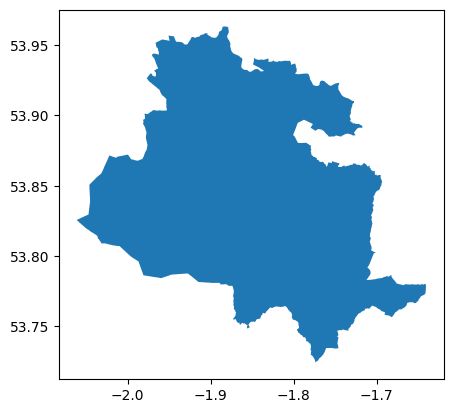

In [6]:
bradford_boundary.plot()

## Postcode Districts

Wikipedia has KML files of postcode areas, which are used under ??? License???

* https://en.wikipedia.org/wiki/Template:Attached_KML/BD_postcode_area
* https://en.wikipedia.org/wiki/Template:Attached_KML/LS_postcode_area

In [7]:
local_files = [
    download(url, RAW / file)
    for (url, file)
    in [
        ("https://en.wikipedia.org/w/index.php?title=Template:Attached_KML/BD_postcode_area&action=raw", 'pcd_districts_bd.kml'),
        ("https://en.wikipedia.org/w/index.php?title=Template:Attached_KML/LS_postcode_area&action=raw", 'pcd_districts_ls.kml'),
        ("https://en.wikipedia.org/w/index.php?title=Template:Attached_KML/HD_postcode_area&action=raw", 'pcd_districts_hd.kml'),
        ("https://en.wikipedia.org/w/index.php?title=Template:Attached_KML/HX_postcode_area&action=raw", 'pcd_districts_hx.kml'),        
    ]
]

This concatenates all district files into a single GeoDataFrame

In [8]:
districts = pd.concat([ gpd.read_file(f, driver="KML") for f in local_files ]).rename(columns=lambda x: x.lower())

In [9]:
districts

,name,description,geometry
0,BD1,BD1 postcode district,"POLYGON ((-1.74898 53.79093, -1.74961 53.79059..."
1,BD2,BD2 postcode district,"POLYGON ((-1.75187 53.80942, -1.75269 53.80792..."
2,BD3,BD3 postcode district,"POLYGON ((-1.74499 53.80774, -1.74386 53.80855..."
3,BD4,BD4 postcode district,"POLYGON ((-1.69307 53.79007, -1.68954 53.79137..."
4,BD5,BD5 postcode district,"POLYGON ((-1.77122 53.7832, -1.77098 53.78455,..."
...,...,...,...
2,HX3,HX3 postcode district,"POLYGON ((-1.85665 53.69681, -1.85901 53.69704..."
3,HX4,HX4 postcode district,"POLYGON ((-1.90945 53.65915, -1.90971 53.65915..."
4,HX5,HX5 postcode district,"POLYGON ((-1.83354 53.67492, -1.83358 53.67479..."
5,HX6,HX6 postcode district,"POLYGON ((-1.97207 53.70638, -1.97218 53.7069,..."


<Axes: >

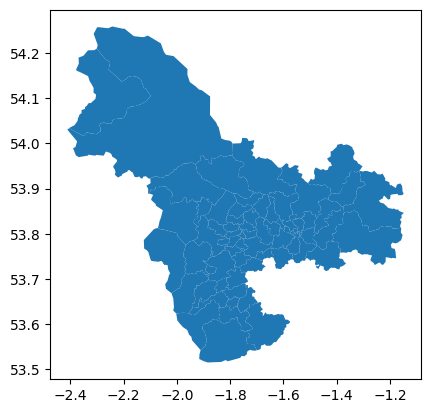

In [10]:
districts.plot()

Now we can clip the districts file

In [11]:
clipped_districts = districts
clipped_districts.geometry = districts.intersection(bradford_boundary.loc[0, 'geometry'])
clipped_districts = clipped_districts.loc[~clipped_districts.is_empty]

In [12]:
clipped_districts

,name,description,geometry
0,BD1,BD1 postcode district,"POLYGON ((-1.74961 53.79059, -1.74964 53.79046..."
1,BD2,BD2 postcode district,"POLYGON ((-1.75269 53.80792, -1.752 53.80764, ..."
2,BD3,BD3 postcode district,"POLYGON ((-1.74386 53.80855, -1.7437 53.8087, ..."
3,BD4,BD4 postcode district,"POLYGON ((-1.68935 53.78186, -1.68936 53.78183..."
4,BD5,BD5 postcode district,"POLYGON ((-1.77098 53.78455, -1.76972 53.78537..."
5,BD6,BD6 postcode district,"POLYGON ((-1.77612 53.77346, -1.77573 53.77316..."
6,BD7,BD7 postcode district,"POLYGON ((-1.75916 53.7922, -1.75817 53.79188,..."
7,BD8,BD8 postcode district,"POLYGON ((-1.80696 53.80433, -1.80576 53.80477..."
8,BD9,BD9 postcode district,"POLYGON ((-1.76908 53.8109, -1.76839 53.81008,..."
9,BD10,BD10 postcode district,"POLYGON ((-1.7486 53.83987, -1.74877 53.84089,..."


<Axes: >

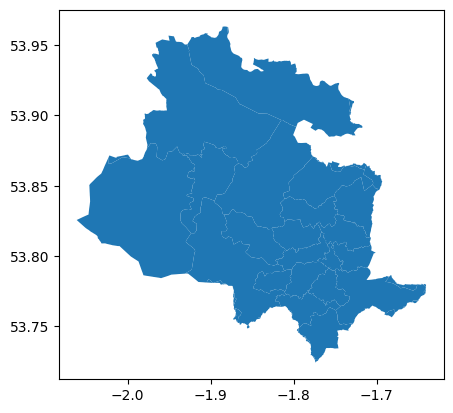

In [13]:
clipped_districts.plot()

In [14]:
clipped_districts.set_crs(None, allow_override=True).to_file(SITE / 'postcodes.geojson')

/home/giles/.local/share/virtualenvs/bd25-L4uOQWuf/lib/python3.12/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
